In [1]:
# !pip3 install torch torchvision

In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch import nn
from torchvision import datasets, transforms, models

In [2]:
# device = torch.device('cuda:10' if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

In [3]:
!ls

811differnet	       Alexnet_2classes.ipynb  black_and_white
Alexnet_2bottle.ipynb  Alexnet_4bottle.ipynb   requirements.txt


In [4]:
!ls black_and_white

train  val


In [5]:
!ls black_and_white/train

black  blacktumbler  silver  white


In [6]:
!ls black_and_white/train/black

0000100.png  0000119.png  000028.png  000046.png  000064.png  000082.png
0000101.png  000011.png   000029.png  000047.png  000065.png  000083.png
0000102.png  0000120.png  00002.png   000048.png  000066.png  000084.png
0000103.png  000012.png   000030.png  000049.png  000067.png  000085.png
0000104.png  000013.png   000031.png  00004.png   000068.png  000086.png
0000105.png  000014.png   000032.png  000050.png  000069.png  000087.png
0000106.png  000015.png   000033.png  000051.png  00006.png   000088.png
0000107.png  000016.png   000034.png  000052.png  000070.png  000089.png
0000108.png  000017.png   000035.png  000053.png  000071.png  00008.png
0000109.png  000018.png   000036.png  000054.png  000072.png  000090.png
000010.png   000019.png   000037.png  000055.png  000073.png  000091.png
0000110.png  00001.png	  000038.png  000056.png  000074.png  000092.png
0000111.png  000020.png   000039.png  000057.png  000075.png  000093.png
0000112.png  000021.png   00003.png   000058.png  000

In [7]:
transform_train = transforms.Compose([transforms.Resize((224,224)),
                                      transforms.RandomHorizontalFlip(),
                                      transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
                                      transforms.ColorJitter(brightness=1, contrast=1, saturation=1),
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                               ]) # try jittervalue 1


transform = transforms.Compose([transforms.Resize((224,224)),
                                transforms.ToTensor(),
                                transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
                               ])

training_dataset = datasets.ImageFolder('black_and_white/train', transform = transform_train)
validation_dataset = datasets.ImageFolder('black_and_white/val', transform = transform)

training_loader = torch.utils.data.DataLoader(training_dataset, batch_size=20, shuffle=True)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=20, shuffle=False)

In [8]:
print("train_len:", len(training_dataset))
print("val_len:", len(validation_dataset))

train_len: 198
val_len: 56


In [9]:
def im_convert(tensor):
  image = tensor.cpu().clone().detach().numpy()
  image = image.transpose(1, 2, 0)
  image = image*np.array((0.5,0.5,0.5)) + np.array((0.5,0.5,0.5))
  image = image.clip(0,1)
  return image

In [10]:
classes = ['black', 'blacktumbler', 'silver', 'white']

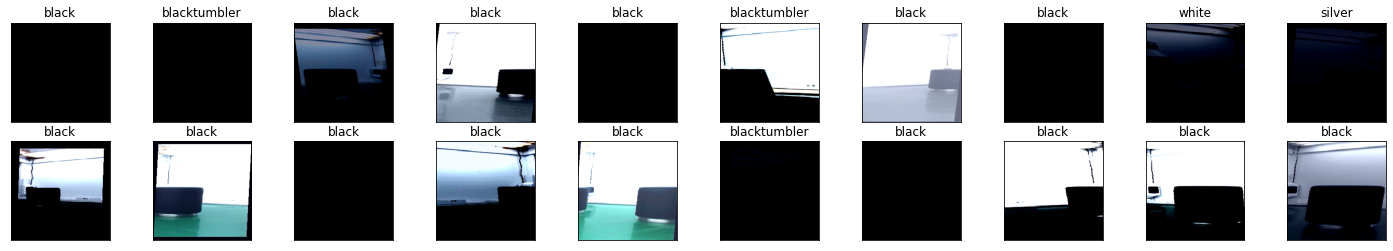

In [11]:
dataiter = iter(training_loader)
images, labels = dataiter.next()
fig = plt.figure(figsize = (25, 4))

for idx in np.arange(20):
  ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
  plt.imshow(im_convert(images[idx]))
  ax.set_title(classes[labels[idx].item()])

In [12]:
model = models.alexnet(pretrained=True)

In [13]:
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [14]:
for param in model.features.parameters():
  param.requires_grad = False

In [15]:
import torch.nn as nn
n_inputs = model.classifier[6].in_features
last_layer = nn.Linear(n_inputs, len(classes))
model.classifier[6] = last_layer
model.to(device)
print(model.classifier[6].out_features)

4


In [16]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.0001) # try different learning rates to see how model works, lower learning rate cause overfiting

In [17]:
epochs = 10
running_loss_history = []
running_corrects_history = []
val_running_loss_history = []
val_running_corrects_history = []

for e in range(epochs):

  running_loss = 0.0
  running_corrects = 0.0
  val_running_loss = 0.0
  val_running_corrects = 0.0

  for inputs, labels in training_loader:
    inputs = inputs.to(device)
    labels = labels.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    _, preds = torch.max(outputs, 1)
    running_loss += loss.item()
    running_corrects += torch.sum(preds == labels.data)


  else:
    with torch.no_grad():
     for val_inputs, val_labels in validation_loader:
      val_inputs = val_inputs.to(device)
      val_labels = val_labels.to(device)
      val_outputs = model(val_inputs)
      val_loss = criterion(val_outputs, val_labels)

      _, val_preds = torch.max(val_outputs, 1)
      val_running_loss += val_loss.item()
      val_running_corrects += torch.sum(val_preds == val_labels.data)


    epoch_loss = running_loss/len(training_loader.dataset)
    epoch_acc = running_corrects.float()/ len(training_loader.dataset)
    running_loss_history.append(epoch_loss)
    running_corrects_history.append(epoch_acc)

    val_epoch_loss = val_running_loss/len(validation_loader.dataset)
    val_epoch_acc = val_running_corrects.float()/ len(validation_loader.dataset)
    val_running_loss_history.append(val_epoch_loss)
    val_running_corrects_history.append(val_epoch_acc)

    print('epoch:', (e+1))
    print('training loss: {:.4f}, acc{:.4f}'.format(epoch_loss, epoch_acc.item()))
    print('validation loss: {:.4f}, validation acc{:.4f}'.format(val_epoch_loss, val_epoch_acc.item()))

epoch: 1
training loss: 0.0495, acc0.6616
validation loss: 0.0267, validation acc0.9107
epoch: 2
training loss: 0.0272, acc0.8333
validation loss: 0.0135, validation acc0.9286
epoch: 3
training loss: 0.0222, acc0.8586
validation loss: 0.0080, validation acc0.9464
epoch: 4
training loss: 0.0196, acc0.8434
validation loss: 0.0153, validation acc0.8750
epoch: 5
training loss: 0.0151, acc0.8838
validation loss: 0.0076, validation acc0.9464
epoch: 6
training loss: 0.0230, acc0.8384
validation loss: 0.0175, validation acc0.9286
epoch: 7
training loss: 0.0191, acc0.8737
validation loss: 0.0038, validation acc1.0000
epoch: 8
training loss: 0.0156, acc0.8889
validation loss: 0.0071, validation acc0.9821
epoch: 9
training loss: 0.0101, acc0.9242
validation loss: 0.0067, validation acc0.9464
epoch: 10
training loss: 0.0114, acc0.9242
validation loss: 0.0054, validation acc0.9821


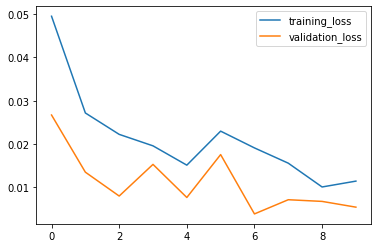

In [18]:
plt.plot(running_loss_history, label = "training_loss")
plt.plot(val_running_loss_history, label = "validation_loss")
plt.legend()

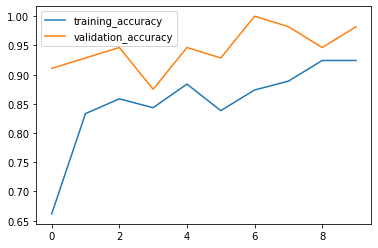

In [19]:
plt.plot(running_corrects_history, label = "training_accuracy")
plt.plot(val_running_corrects_history, label = "validation_accuracy")
plt.legend()

In [20]:
!pip3 install pillow==5.2.0

  Using cached Pillow-5.2.0.tar.gz (14.5 MB)
Using legacy 'setup.py install' for pillow, since package 'wheel' is not installed.
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0
    Running setup.py install for pillow ... done
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

matplotlib 3.5.0 requires pillow>=6.2.0, but you'll have pillow 5.2.0 which is incompatible.
You should consider upgrading via the '/home/lihang/chenggui/811test/.env/bin/python3.8 -m pip install --upgrade pip' command.


In [21]:
import PIL.ImageOps

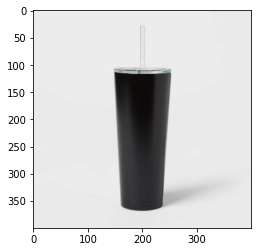

In [22]:
import requests
from PIL import Image

img1 = Image.open(r'test/1.jpg')
plt.imshow(img1)

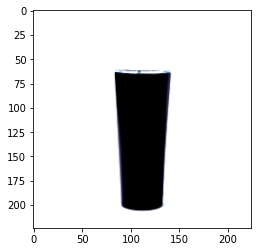

In [23]:
img1 = transform(img1)
plt.imshow(im_convert(img1))

In [24]:
image1 = img1.to(device).unsqueeze(0)
output = model(image1)
_, pred = torch.max(output, 1)
print(classes[pred.item()])
# prediciton is wrong. it should be black tumbler

black


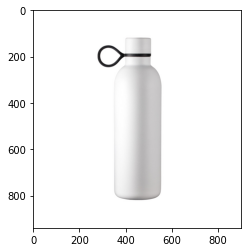

In [28]:
import requests
from PIL import Image

img2 = Image.open(r'test/3.jpg')
plt.imshow(img2)

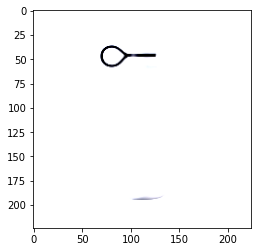

In [29]:
img2 = transform(img2)
plt.imshow(im_convert(img2))

In [30]:
image2 = img2.to(device).unsqueeze(0)
output = model(image2)
_, pred = torch.max(output, 1)
print(classes[pred.item()])

white
